In [1]:
from qiskit.chemistry import QiskitChemistry
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

In [52]:
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [40]:
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.aqua.operators import Z2Symmetries

# Use PySCF, a classical computational chemistry software
# package, to compute the one-body and two-body integrals in
# molecular-orbital basis, necessary to form the Fermionic operator


### Used basis sets sto-3g, sto-6g and a custom made basis set with 4 primitives, based on the sto-3g model.
driver_1 = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
#     atom='Be .0 .0 .0',
    unit=UnitsType.ANGSTROM,
    basis='sto-6g'
)

molecule1 = driver_1.run()

num_particles = molecule1.num_alpha + molecule1.num_beta
num_spin_orbitals = molecule1.num_orbitals * 2

# Build the qubit operator, which is the input to the VQE algorithm in Aqua
ferm_op = FermionicOperator(h1=molecule1.one_body_integrals, h2=molecule1.two_body_integrals)
map_type = 'PARITY'
qubit_op = ferm_op.mapping(map_type)
qubit_op = Z2Symmetries.two_qubit_reduction(qubit_op, num_particles)

num_qubits = qubit_op.num_qubits

In [41]:
num_qubits

2

In [42]:
# IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_london")
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
quantum_instance = QuantumInstance(backend=backend, shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30,)

In [43]:
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP


exact_solution = ExactEigensolver(qubit_op).run()
print("Exact Result:", exact_solution['energy'])
vqe_error = []
for i in range(10):
    optimizer = SPSA(max_trials=100)
    var_form = RYRZ(qubit_op.num_qubits, depth=1, entanglement="linear")
    vqe = VQE(qubit_op, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_error.append(ret)
    print("VQE Result:", ret['energy'])

Exact Result: -1.865946848303367
VQE Result: -1.8402386444337213
VQE Result: -1.8462911533074875
VQE Result: -1.827556736838582
VQE Result: -1.8205726252768444
VQE Result: -1.8290236158798592
VQE Result: -1.8622559936961787
VQE Result: -1.8170452279748976
VQE Result: -1.846926776122843
VQE Result: -1.834255228907307
VQE Result: -1.8459817512580203


In [88]:
custom_diff = np.zeros(10)
custom = np.zeros(10)
custom_exact = -1.863980204745825
for ind, i in enumerate(vqe_error_custom):
    custom_diff[ind] = (custom_exact - i['energy'])/custom_exact
    custom[ind] = i['energy']

sto36_diff = np.zeros(10)
sto36 = np.zeros(10)
sto36_exact =  -1.8572750302023795
for ind, i in enumerate(vqe_error_sto36):
    sto36_diff[ind] = (sto36_exact - i['energy'])/sto36_exact
    sto36[ind] = i['energy']

sto6g_diff = np.zeros(10)
sto6g = np.zeros(10)
sto6g_exact =  -1.8659468483033668
for ind, i in enumerate(vqe_error_sto6g):
    sto6g_diff[ind] = (sto6g_exact - i['energy'])/sto6g_exact
    sto6g[ind] = i['energy']

In [64]:
np.array((sto36_diff, sto6g_diff, custom_diff)).reshape(3,-1)

array([[ 0.01453798,  0.00544111,  0.00687241, -0.0070233 ,  0.01528368,
        -0.00326263,  0.04470552,  0.00542986,  0.00666537,  0.00976504],
       [ 0.01377756,  0.0105339 ,  0.02057406,  0.024317  ,  0.01978793,
         0.00197801,  0.0262074 ,  0.01019326,  0.0169842 ,  0.01069971],
       [ 0.01381631,  0.02108314,  0.00443019,  0.01252709,  0.00733369,
         0.01075318,  0.01224058, -0.002892  , -0.0015054 ,  0.00528824]])

In [91]:
import pandas as pd
df_err = pd.DataFrame({
    'Sto-3g':sto36_diff,
    'Sto-6g':sto6g_diff,
    'Custom':custom_diff
})

In [92]:
import pandas as pd
df_abs = pd.DataFrame({
    'Sto-3g':sto36,
    'Sto-6g':sto6g,
    'Custom':custom
})

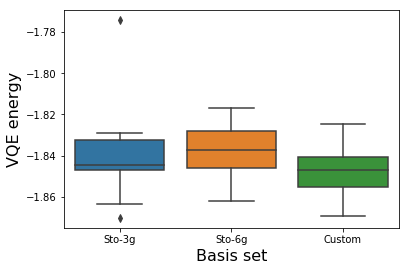

In [96]:
plt.figure()
sns.boxplot(data=df_abs)
plt.xlabel('Basis set', fontsize=16)
plt.ylabel('VQE energy', fontsize=16)
plt.savefig('energy.svg')
plt.show()

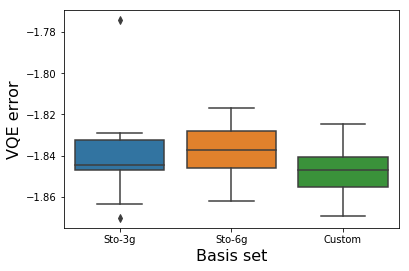

In [97]:
plt.figure()
sns.boxplot(data=df)
plt.xlabel('Basis set', fontsize=16)
plt.ylabel('VQE error', fontsize=16)
plt.savefig('error.svg')
plt.show()

#### Custom basis set
Exact Result: -1.863980204745825

VQE Result: -1.8610623985692292


#### sto-6g
Exact Result: -1.8659468483033668

VQE Result: -1.8278448308106983

#### sto-3g
Exact Result: -1.8572750302023795

VQE Result: -1.820852743190272

#### Quantum computer results, 'ibmq_london'

In [108]:
results_london_sto6g = {'num_optimizer_evals': 629,
 'min_val': -1.0142192398264571,
 'opt_params': np.array([ 2.27752398,  0.79634372, -2.51407064, -2.26576987,  1.8153314 ,
         0.94964863,  0.67225825, -1.77405256,  2.95903293,  1.14235818,
        -2.91578481, -1.75351476,  1.02956838, -1.52793422, -1.71106192,
        -2.99411911]),
 'eval_time': 18287.572997808456,
 'eval_count': 629,
 'energy': -1.0142192398264571,
 'eigvals': np.array([-1.01421924]),
 'min_vector': {'10': 406, '01': 286, '11': 246, '00': 86},
 'eigvecs': np.array([{'10': 406, '01': 286, '11': 246, '00': 86}], dtype=object)}

In [107]:
results_london_sto3g = {'num_optimizer_evals': 357,
 'min_val': -1.408254604138296,
 'opt_params': np.array([-1.42989625, -3.01322002, -1.67264651, -1.26385378,  2.53638967,
        -2.87994314, -3.13034822,  1.97084416,  1.35331415, -2.59657741,
         1.30744208,  2.55582108, -1.00614974, -0.54306608, -1.82895393,
        -3.1249087 ]),
 'eval_time': 8668.539556264877,
 'eval_count': 357,
 'energy': -1.408254604138296,
 'eigvals': np.array([-1.4082546]),
 'min_vector': {'10': 88, '01': 355, '11': 164, '00': 417},
 'eigvecs': np.array([{'10': 88, '01': 355, '11': 164, '00': 417}], dtype=object)}

### Looking at the circuit and introducing errors.

In [103]:
device = provider.get_backend('ibmq_london')
properties = device.properties()
coupling_map = device.configuration().coupling_map

In [99]:
circ = QuantumCircuit(2, 2)
circ.u3(3.141592653589793, 0, 3.141592653589793, 0)
circ.u3(-1.4298962526954144, 0, 0, 0) 
circ.u1(-3.0132200242040166, 0) 
circ.u3(-1.672646508888292, 0, 0, 1) 
circ.u1(-1.2638537769565306, 1) 
circ.barrier(0,1) 
circ.u2(0, 3.141592653589793, 1)
circ.cx(0,1)
circ.u2(0, 3.141592653589793, 1)
circ.barrier(0,1)
circ.u3(2.5363896658921723, 0, 0, 0)
circ.u1(-2.8799431393126755, 0)
circ.u3(-3.1303482114122025, 0, 0, 1)
circ.u1(1.9708441602329927, 1)
circ.barrier(0,1)
circ.u2(0, 3.141592653589793, 1)
circ.cx(0, 1)
circ.u2(0, 3.141592653589793, 1)
circ.barrier(0, 1)
circ.u3(1.3533141530874673, 0, 0, 0)
circ.u1(-2.5965774125185686, 0)
circ.u3(1.3074420802920157, 0, 0, 1)
circ.u1(2.5558210812842406, 1)
circ.barrier(0,1)
circ.u2(0, 3.141592653589793, 1)
circ.cx(0, 1)
circ.u2(0, 3.141592653589793, 1)
circ.barrier(0, 1)
circ.u3(-1.0061497415052236, 0, 0, 0)
circ.u1(-0.5430660795643898, 0)
circ.u3(-1.8289539285225809, 0, 0, 1)
circ.u1(-3.1249086977295537, 1)
circ.barrier(0, 1)
circ.u2(0, 3.141592653589793, 0)
circ.barrier(0)
circ.u2(0, 3.141592653589793, 1)
circ.barrier(1)
circ.measure(0, 0)
circ.measure(1, 1)

In [100]:
circ.draw()

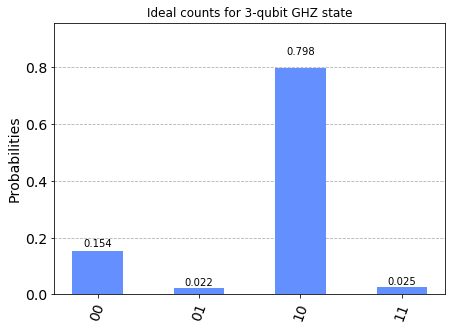

In [101]:
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

In [104]:
gate_times = [
    ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
    ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
    ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
    ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
    ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
    ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
    ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
]
noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['id', 'cx', 'measure', 'u3', 'u2']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


/home/jurgis/anaconda3/envs/htvs/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/models.py:114: DeprecationWarning: gate_times kwarg is deprecated and will be removed in a future release. Use gate_lengths kwarg instead.
  DeprecationWarning)


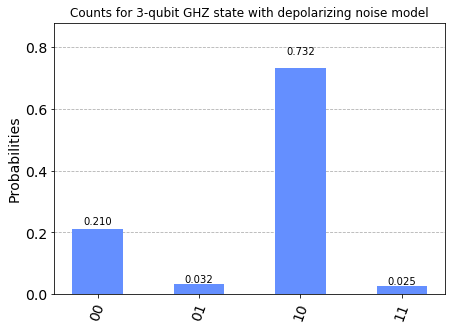

In [105]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(circ, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")